<a href="https://colab.research.google.com/github/smithakolan/Machine-learning-Tutorials/blob/main/Disaster_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!gdown --id 1NvTyhUsrFbL91E10EPm38IjoCg6E2c6q

Downloading...
From: https://drive.google.com/uc?id=1NvTyhUsrFbL91E10EPm38IjoCg6E2c6q
To: /content/Cyclone_Wildfire_Flood_Earthquake_Database.zip
1.90GB [00:16, 114MB/s] 
Archive:  /content/Cyclone_Wildfire_Flood_Earthquake_Database.zip
checkdir:  cannot create extraction directory: /content/data
           File exists


In [ ]:
!unzip '/content/Cyclone_Wildfire_Flood_Earthquake_Database.zip' -d '/content/data'

Archive:  /content/Cyclone_Wildfire_Flood_Earthquake_Database.zip
   creating: /content/data/Cyclone_Wildfire_Flood_Earthquake_Database/
   creating: /content/data/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/
  inflating: /content/data/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/0.jpg  
  inflating: /content/data/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/1.jpg  
  inflating: /content/data/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/10.jpg  
  inflating: /content/data/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/100.jpg  
  inflating: /content/data/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/101.jpg  
  inflating: /content/data/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/102.jpg  
  inflating: /content/data/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/103.jpg  
  inflating: /content/data/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/104.jpg  
  inflating: /content/data/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/105.jpg

In [ ]:
data/
  Cyclone_Wildfire_Flood_Earthquake/
    Cyclone/
    Earthquake/
    Flood/
    Wildfire/

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/data/Cyclone_Wildfire_Flood_Earthquake_Database/')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4428


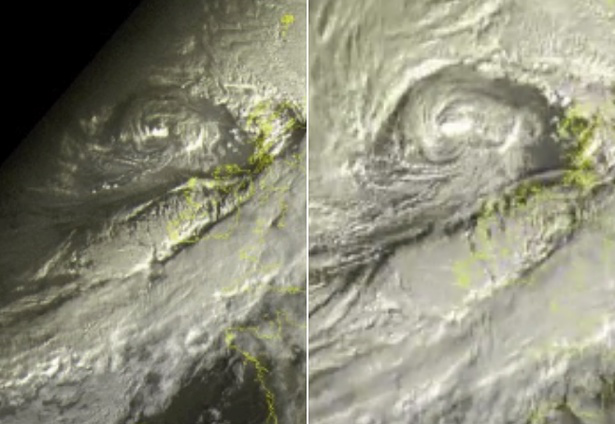

In [ ]:
cyclones = list(data_dir.glob('Cyclone/*'))
PIL.Image.open(str(cyclones[0]))

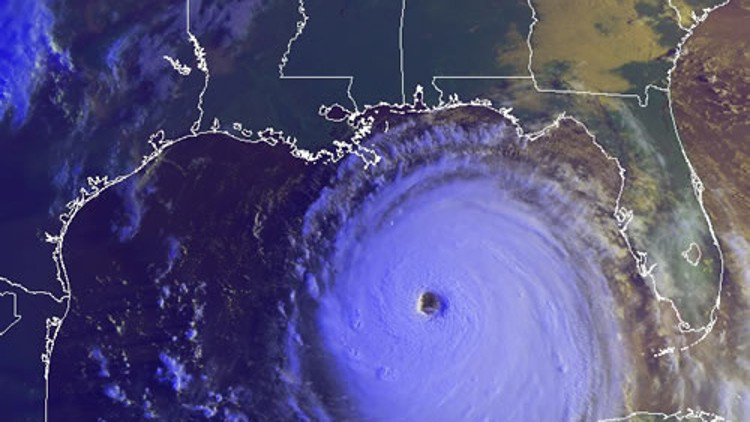

In [ ]:
PIL.Image.open(str(cyclones[1]))

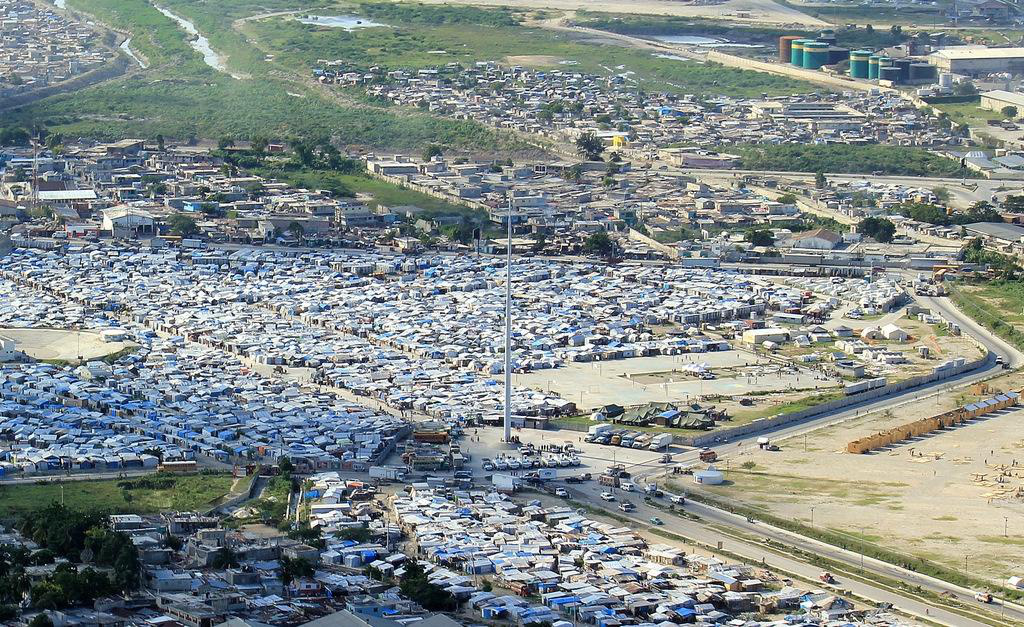

In [ ]:
earthquakes = list(data_dir.glob('Earthquake/*'))
PIL.Image.open(str(earthquakes[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4428 files belonging to 4 classes.
Using 3543 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4428 files belonging to 4 classes.
Using 885 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Cyclone', 'Earthquake', 'Flood', 'Wildfire']


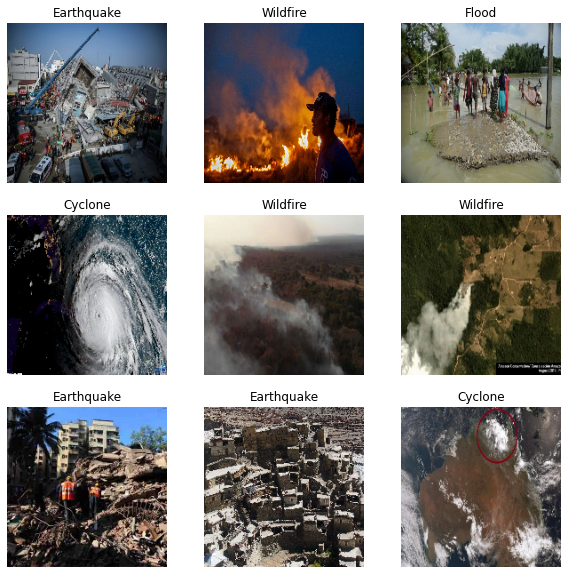

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0004901961 1.0


Create the model

In [ ]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

Train the model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
111/111 [==============================] - 107s 960ms/step - loss: 1.0514 - accuracy: 0.5865 - val_loss: 0.7481 - val_accuracy: 0.7232
Epoch 2/10
111/111 [==============================] - 100s 898ms/step - loss: 0.5896 - accuracy: 0.7787 - val_loss: 0.5138 - val_accuracy: 0.8226
Epoch 3/10
111/111 [==============================] - 100s 898ms/step - loss: 0.4829 - accuracy: 0.8233 - val_loss: 0.4874 - val_accuracy: 0.8305
Epoch 4/10
111/111 [==============================] - 100s 898ms/step - loss: 0.3679 - accuracy: 0.8704 - val_loss: 0.5219 - val_accuracy: 0.8328
Epoch 5/10
111/111 [==============================] - 100s 899ms/step - loss: 0.2638 - accuracy: 0.9063 - val_loss: 0.4932 - val_accuracy: 0.8215
Epoch 6/10
111/111 [==============================] - 100s 900ms/step - loss: 0.1740 - accuracy: 0.9438 - val_loss: 0.5102 - val_accuracy: 0.8520
Epoch 7/10
111/111 [==============================] - 103s 930ms/step - loss: 0.1119 - accuracy: 0.9605 - val_loss: 0.5806 -

Visualize training results

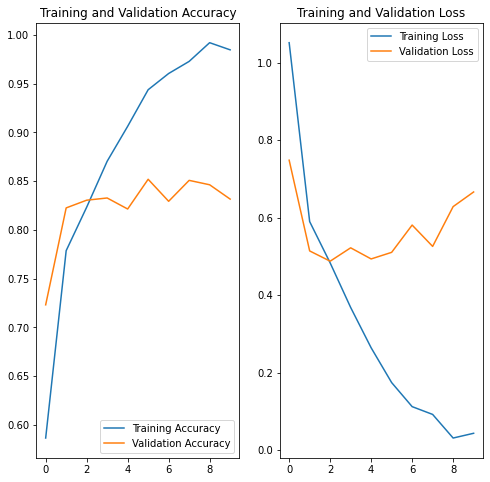

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Overfitting

Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

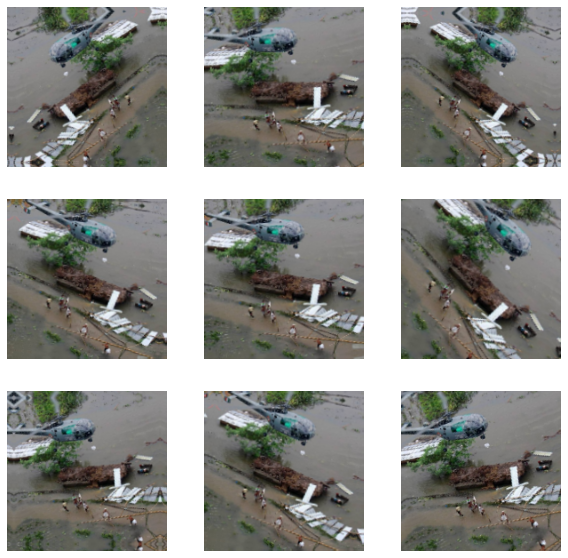

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Dropout

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
111/111 [==============================] - 116s 1s/step - loss: 1.0444 - accuracy: 0.5574 - val_loss: 1.0426 - val_accuracy: 0.6825
Epoch 2/15
111/111 [==============================] - 115s 1s/step - loss: 0.5983 - accuracy: 0.7858 - val_loss: 0.9120 - val_accuracy: 0.6836
Epoch 3/15
111/111 [==============================] - 115s 1s/step - loss: 0.5204 - accuracy: 0.8163 - val_loss: 0.6522 - val_accuracy: 0.7695
Epoch 4/15
111/111 [==============================] - 115s 1s/step - loss: 0.4806 - accuracy: 0.8213 - val_loss: 0.5589 - val_accuracy: 0.8158
Epoch 5/15
111/111 [==============================] - 115s 1s/step - loss: 0.4484 - accuracy: 0.8326 - val_loss: 0.5924 - val_accuracy: 0.8068
Epoch 6/15
111/111 [==============================] - 115s 1s/step - loss: 0.4054 - accuracy: 0.8507 - val_loss: 0.6626 - val_accuracy: 0.7819
Epoch 7/15
111/111 [==============================] - 115s 1s/step - loss: 0.3961 - accuracy: 0.8569 - val_loss: 0.9229 - val_accuracy: 0.7367

Visualize training results

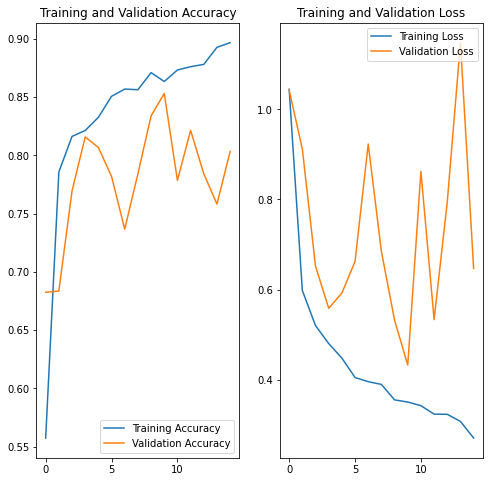

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict on new data

In [47]:
!wget -O floodtest.jpg "https://www.aljazeera.com/wp-content/uploads/2021/02/2021-02-20T052154Z_2038680568_RC25WL98FKZ7_RTRMADP_3_INDONESIA-FLOODS.jpg"
testImage_path = pathlib.Path('/content/floodtest.jpg')

img = keras.preprocessing.image.load_img(
    testImage_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

--2021-06-24 16:50:58--  https://www.aljazeera.com/wp-content/uploads/2021/02/2021-02-20T052154Z_2038680568_RC25WL98FKZ7_RTRMADP_3_INDONESIA-FLOODS.jpg
Resolving www.aljazeera.com (www.aljazeera.com)... 23.192.67.222, 2600:1408:9000:184::2392, 2600:1408:9000:18c::2392
Connecting to www.aljazeera.com (www.aljazeera.com)|23.192.67.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3020743 (2.9M) [image/jpeg]
Saving to: ‘floodtest.jpg’

floodtest.jpg       100%[===================>]   2.88M  --.-KB/s    in 0.08s   

2021-06-24 16:50:59 (38.4 MB/s) - ‘floodtest.jpg’ saved [3020743/3020743]

This image most likely belongs to Earthquake with a 93.97 percent confidence.
